In [47]:
import torch
import torch.nn.functional as F
import pathlib
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.patches import Polygon
import numpy as np
from scipy.spatial import ConvexHull
import pandas as pd

# Load the Model from the LTH experiement

In pytorch there are state-dicts. Dictionaries that contain all the learnable parameters

In [48]:
class MNIST_LENET_300_100_Experiment:

    def __init__(self, experiment_path, layermap=None):
        self.path = experiment_path

        # count the number of directories, levels in the experiment
        self.num_levels = len(next(os.walk(experiment_path))[1])
        self.state_dict = None
        self.current_path = None

        # the standard layermap of the mnist_lenet_300_100 experiment. 
        # these are the names in the .pth file
        if layermap is None:
            self.layermap = (
                "fc_layers.0.weight",
                "fc_layers.1.weight",
                "fc.weight",
            )
        else:
            self.layermap = layermap

        self.num_layers = len(self.layermap)

        # parse out the number of iterations
        path = os.path.join(self.path, f'level_0')
        path = os.path.join(path, 'main')

        names = [name for name in os.listdir(path) if "model" in name]
        assert len(names) == 2, "Not yet possible for more than 2 .pth files automagically."
        for name in names:

            name = name.split(".")[0]
            _,ep,it = name.split("_")
            ep = ep.split("ep")[1]
            it = it.split("it")[1]
            if ep != 0:
                self.ep = int(ep)
            if it != 0:
                self.it = int(it)
    
    def get_state_dict(self, level, ep=0, it=0):
        if level > self.num_levels:
            raise ValueError(f"There are only {self.num_levels} levels")

        level_name = f'level_{level}'
        path = os.path.join(self.path, level_name)
        path = os.path.join(path, 'main')
        path = os.path.join(path, f'model_ep{ep}_it{it}.pth')

        if self.current_path != path:
            self.state_dict = torch.load(path)

        return self.state_dict

    def get_mask(self, level):
        level_name = f'level_{level}'
        path = os.path.join(self.path, level_name)
        path = os.path.join(path, 'main')
        path = os.path.join(path, f'mask.pth')
        return torch.load(path)

    def map_layer_name(self, layer: int):
        """Map a numeric value that indicates layer
        index starting at 0 (input layer) to name in state dict"""
        try:
            return self.layermap[layer]
        except:
            raise ValueError(f"There are only {len(self.layermap)} layers, not {layer}")
    
    def weights(self, 
            level: int, # the pruning level
            layer: int, # the layer of the Network
            it: int = 0,    # the iteration during the level
            ep: int = 0     # the epoch during level
            ):
        """Get the weights of a level in a layer at certain point in level."""

        layer_name = self.map_layer_name(layer)
        state_dict = self.get_state_dict(level, ep, it)
        return state_dict[layer_name].cpu()
    
    def mask(self, 
            level: int, # the pruning level
            layer: int, # the layer of the Network
            ):
        layer_name = self.map_layer_name(layer)
        return self.get_mask(level)[layer_name].cpu() == 1

        

e = MNIST_LENET_300_100_Experiment(
    pathlib.Path('open_lth_data/lottery_exp1/replicate_1')
    )
# check the masking 

assert e.weights(1,0)[~e.mask(1,0)].any() == False, "mask must not cover any non-zero"
assert e.weights(0,0)[e.mask(0,0)].all() == True
assert e.weights(2,2)[e.mask(2,2)].all() == True, "mask must cover all zeros"
assert e.weights(2,2)[e.mask(1,2)].all() == False, "earliear mask does not cover all removed elements"

# Create an Experiment
Everything is encapsulated in the Experiment Class

In [49]:
experiment_1 = MNIST_LENET_300_100_Experiment(
    pathlib.Path('open_lth_data/lottery_exp1/replicate_1')
    )
experiment_2 = MNIST_LENET_300_100_Experiment(
    pathlib.Path('open_lth_data/lottery_exp2_seedset/replicate_1')
    )
e = experiment_2

In [50]:
class direct_access_cmap():
    def __init__(self, n, style="cool"):
        self.n = n
        self.cmap = mpl.cm.get_cmap(style, n)    # a discrete colormap
    def __call__(self, idx):
        return self.cmap(idx/self.n)

def get_pruned_and_remaining_weights(x_t, m_t_plus_1)-> tuple:
    """Returns the newly pruned weights with the new mask."""
    X=x_t
    m=m_t_plus_1
    removed_weights_idx = X[~m].nonzero(as_tuple=False)
    removed_weights = X[~m][removed_weights_idx].squeeze()
    #removed_weights.size(dim=0)
    assert removed_weights.all(), "all newly pruned weights must be nonzero! there might be coincidences where a unpruned weights is actually 0. but highly unlikely"
    return removed_weights, X[m]

# test get pruned weights
for level in range(e.num_levels-1):
    X = e.weights(level,0) # current weights
    m = e.mask(level+1,0) # next mask
    _m = e.mask(level,0) # current mask

    # get the weights that are pruned and the ones that remain
    pruned, remaining = get_pruned_and_remaining_weights(X,m)
    assert pruned.size(0) +remaining.size(0) == X[_m].numel(), (pruned.size(0), remaining.size(0), " summed must equal ", X[_m].numel())

def find_dead_features(X, shape, ax , title="", cmap=None):
    X = X.reshape(-1, 28,28)
    N = X.shape[0]
    nonzero = torch.count_nonzero(X, dim=0)
    if cmap == None:
        cmap = mpl.colormaps.get_cmap("turbo").copy()
        cmap.set_bad("k")
    #ax.set_title(f"{title}, \n val: [{nonzero.min().item(),nonzero.max().item()}]")
    ax.set_title(f"{title}, \n {range_ltx(nonzero)}")
    im = ax.imshow(nonzero, cmap=cmap, vmin=0, vmax=N)

    return im

def range_ltx(x):
    return f"values $\in [{x.min().item()}, {x.max().item()}]$"

def plot_weight_distribution(x, ax, label="", title="", include_zeros=False, curves=False, density=True, color=None):
    #frequency, bins = torch.histogram(x, bins=10)
    
    x = torch.flatten(x)
    x = torch.where(x != 0, x, torch.nan)
    ax.title.set_text(title)
    if curves: # a lot faster
        x = x[np.isfinite(x)]
        counts, bins = np.histogram(x, bins=64, density=density)
        ax.plot(bins[:-1], counts, label=label, color=color)
        ax.legend()
    else:
        print("not implemented....")
        #ax.hist(x, bins=64, histtype="step")
    
    # ax.plot(data[0])
    

def morph_distributions(distlist, density=True, ax=None, fig=None, cmap=None, title=""):
    """Create a Plot overlappinng a list of densities normalized on a new fig if not provided."""
    cmap = direct_access_cmap(len(distlist))
    # a discrete colormap

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6,6), constrained_layout=True)

    curves=True
    for i, (dist, label) in enumerate(distlist):
        plot_weight_distribution(
            x=dist,
            ax=ax,
            label=label,
            title=title,
            include_zeros=False,
            curves=curves,
            density=density, # unnormalized makes no sense
            color=cmap(i+1) 
        )
    fig.suptitle(f'Morph Distributions {title}', fontsize=16)

def points_to_convvex_hull_polygon(points):
    """Turn a array of points, shape (N,2) into a a polygon of its complex hull."""
    points = np.array(points)
    hull = ConvexHull(points)
    cent = np.mean(points, axis=0)
    pts = points[hull.vertices]
    k = 1
    return Polygon(
        k*(pts - cent) + cent, # for adding some padding around it. 
        closed=True,
        capstyle='round',
        facecolor="none",
        edgecolor="red",
        linewidth=2,
        alpha=0.2)

def get_outer_shell_2d_matrix(input, pad=1):
    """Get the outer shell of a 2d matrix including batch dimension.
    (N,X,Y) -> shell = (N*pad*pad), core = N*(X-pad)*(Y-pad))
    """
    import torch.nn.functional as F
    N, x, y = input.shape
    source = torch.zeros((x-2*pad,y-2*pad), dtype=torch.bool)
    mask = F.pad(input=source, pad=(pad,pad,pad,pad), mode='constant', value=True)
    mask = mask.reshape(1,x,y)
    mask = np.tile(mask.T, N).T

    assert mask.shape == input.shape

    return input[mask], input[~mask]

# testing if it is correct
# create 300x28x28 tensor with
pad=1
source = torch.zeros((26,26), dtype=torch.bool)
test = F.pad(input=source, pad=(pad,pad,pad,pad), mode='constant', value=True)
test = test.reshape(1,28,28)
test = np.tile(test.T, 300).T
shell, core = get_outer_shell_2d_matrix(test, pad=1)
assert np.all(shell) == True, "The outer shell must be true!"
assert np.any(core) == False, "The inner core must be false!"

# Plots!
Specify an experiment

/var/folders/9n/yxn6g0xn02q48jb1vzdss0hm0000gn/T/ipykernel_1232/2009044244.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/9n/yxn6g0xn02q48jb1vzdss0hm0000gn/T/ipykernel_1232/2009044244.py:51: UserWarning:

indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/native/IndexingUtils.h:28.)



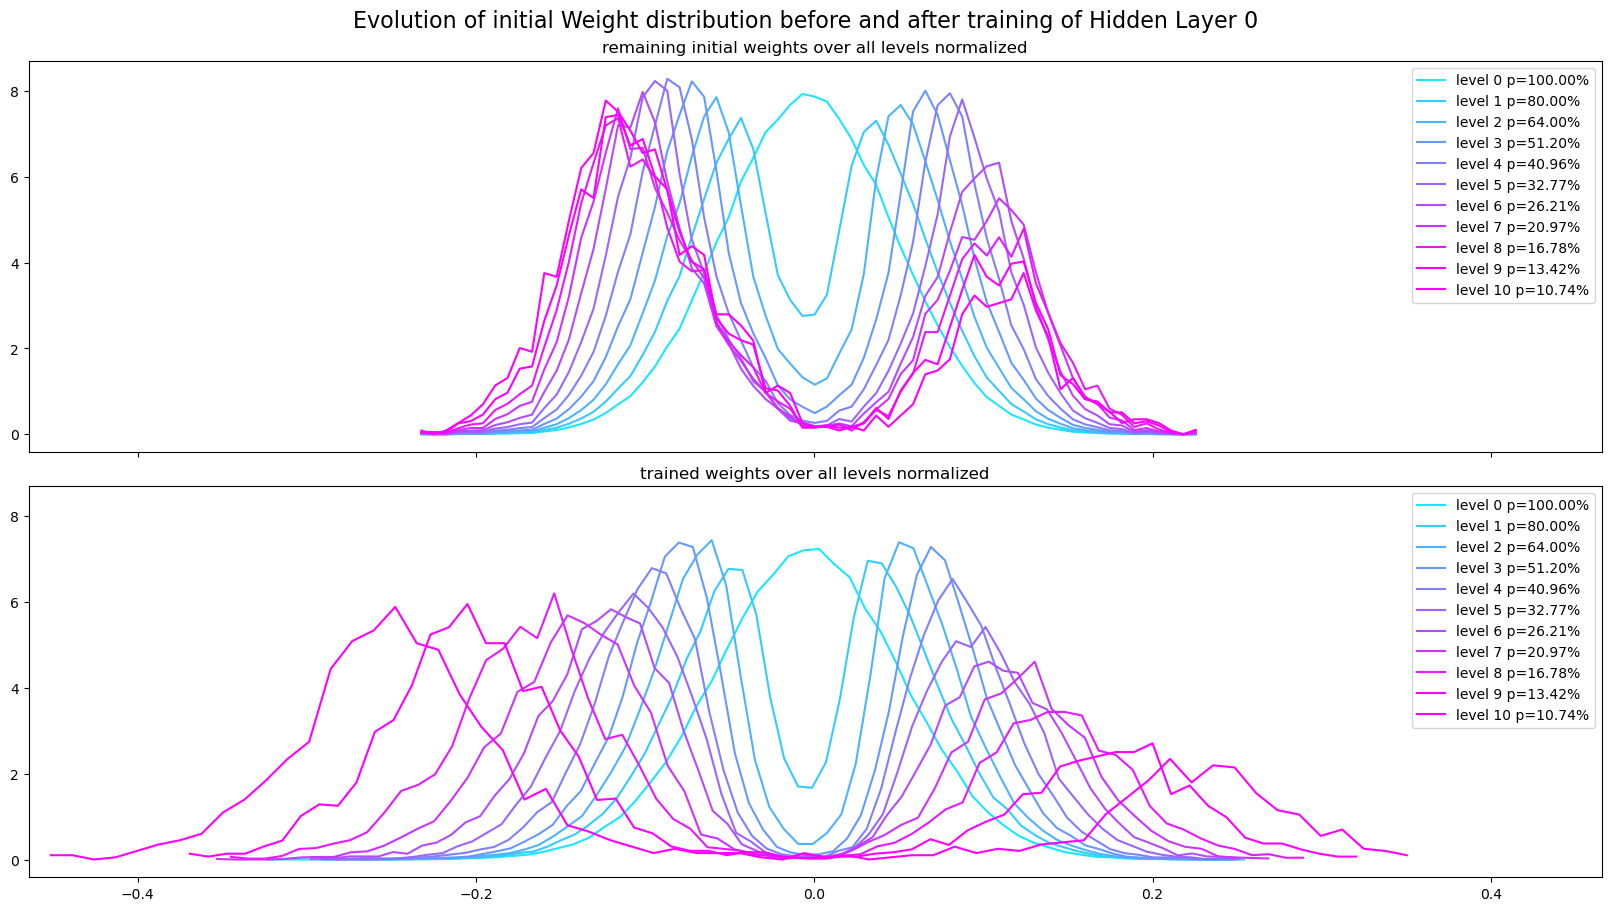

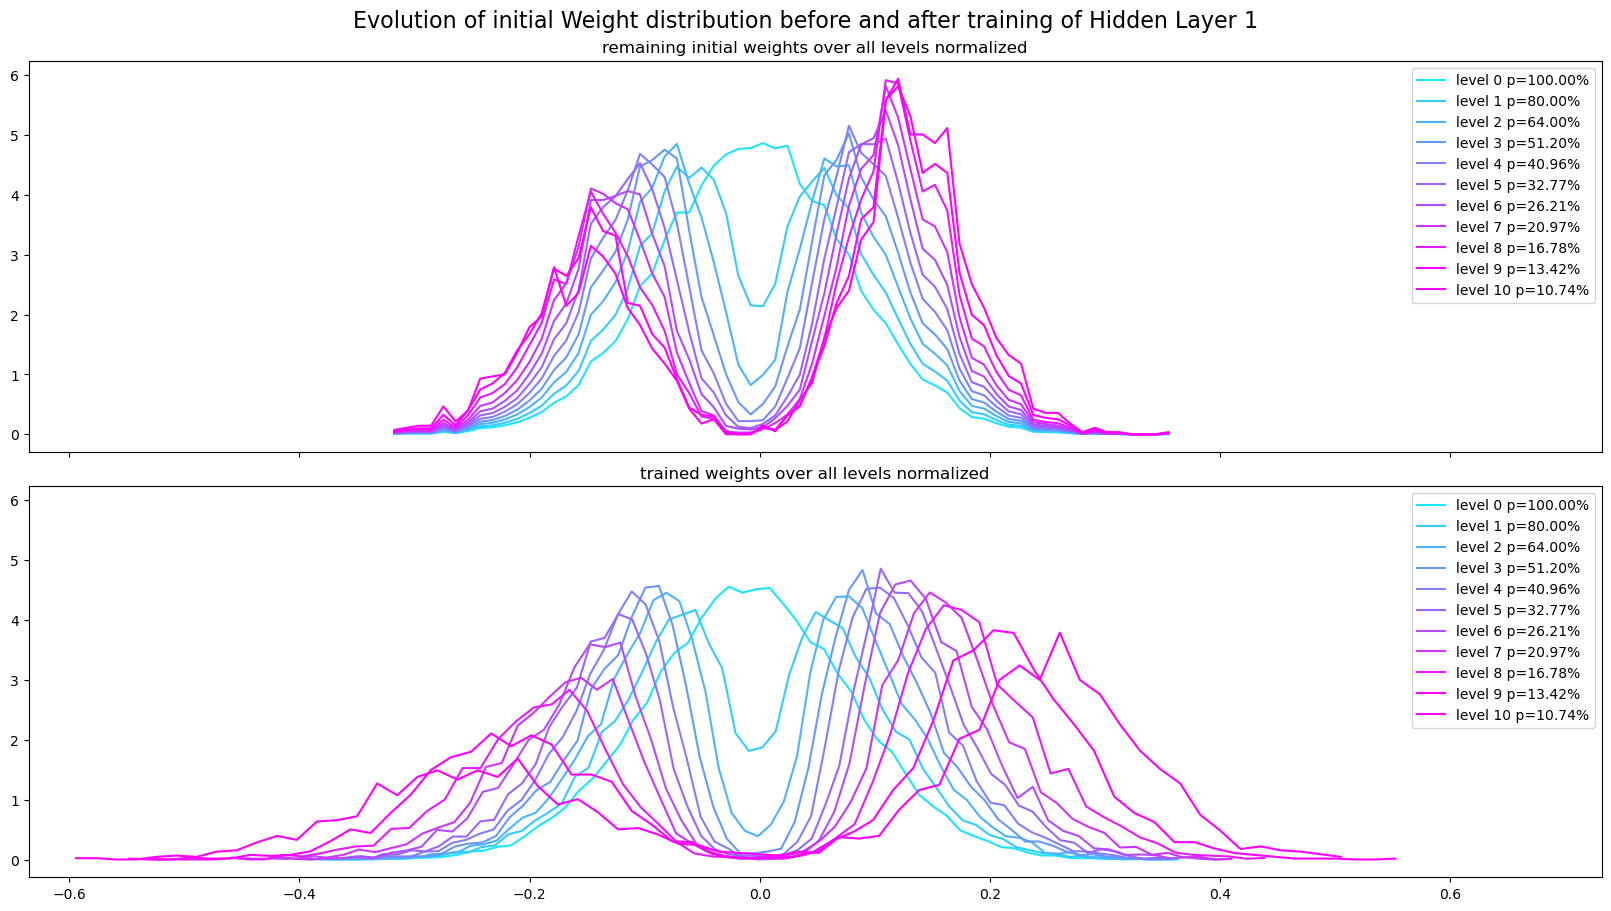

In [51]:
for layer in [0,1]:
    fig, ax = plt.subplots(2, 1, figsize=(16,9), constrained_layout=True, sharey=True, sharex=True)
    density = True
    curves=True

    morph_distributions(
        distlist=[ (e.weights(level=i, layer=layer),f"level {i} p={(100*(0.8**i)):.2f}%") for i in range(e.num_levels)],
        ax=ax[0],
        fig=fig,
        title=f"remaining initial weights over all levels {'normalized' if density else 'unnormalized'}",
        density=density
    )
    morph_distributions(
        distlist=[ (e.weights(level=i, layer=layer, it=e.it, ep=e.ep), f"level {i} p={(100*(0.8**i)):.2f}%") for i in range(e.num_levels)],
        ax=ax[1],     
        fig=fig,
        title=f"trained weights over all levels {'normalized' if density else 'unnormalized'}",
        density=density
    )

    # View twice the range as min and max from weights at init
    _ = e.weights(level=0, layer=layer)
    ax[0].set_xlim(_.min()*2,_.max()*2)
    
    fig.suptitle(f'Evolution of initial Weight distribution before and after training of Hidden Layer {layer}', fontsize=16)

Text(0.5, 0.98, 'Fraction of Pruned weights wo/ weight updates')

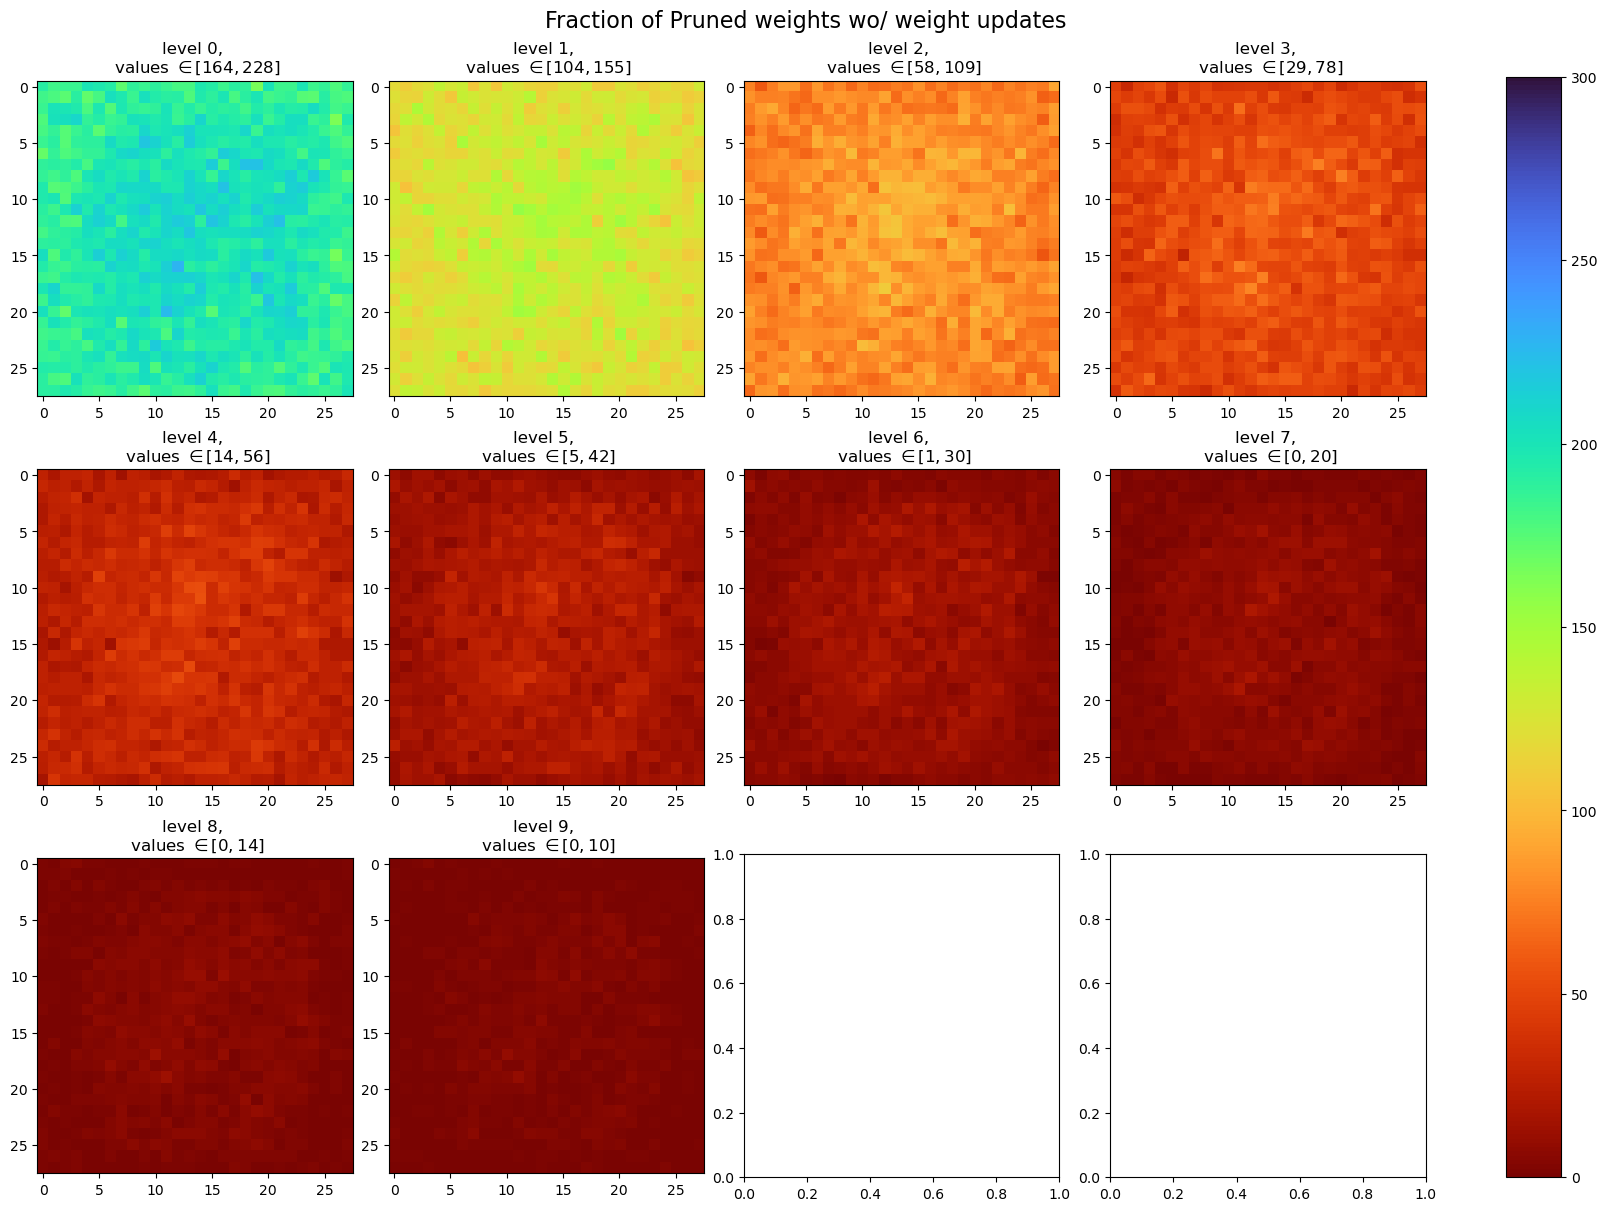

In [52]:
plot_levels = e.num_levels - 1

n_cols = 4 # number of plots next to each other
n_rows = plot_levels // n_cols + (0 if plot_levels % n_cols == 0 else 1)

cmap = mpl.colormaps.get_cmap("turbo").copy().reversed()
cmap.set_bad("k")

fig, ax = plt.subplots( n_rows, n_cols, figsize=(n_cols*4,n_rows*4), constrained_layout=True)
for i in range(0, plot_levels):
    row, col = i // n_cols , i % n_cols
    im = find_dead_features(
        e.weights(level=i+1, layer=0),
        (28,28), 
        ax[row,col],
        title=f"level {i}",
        cmap=cmap
    )

fig.colorbar(
        im,
        ax=ax,
        shrink=1.0
    )
fig.suptitle('Fraction of Pruned weights wo/ weight updates', fontsize=16)

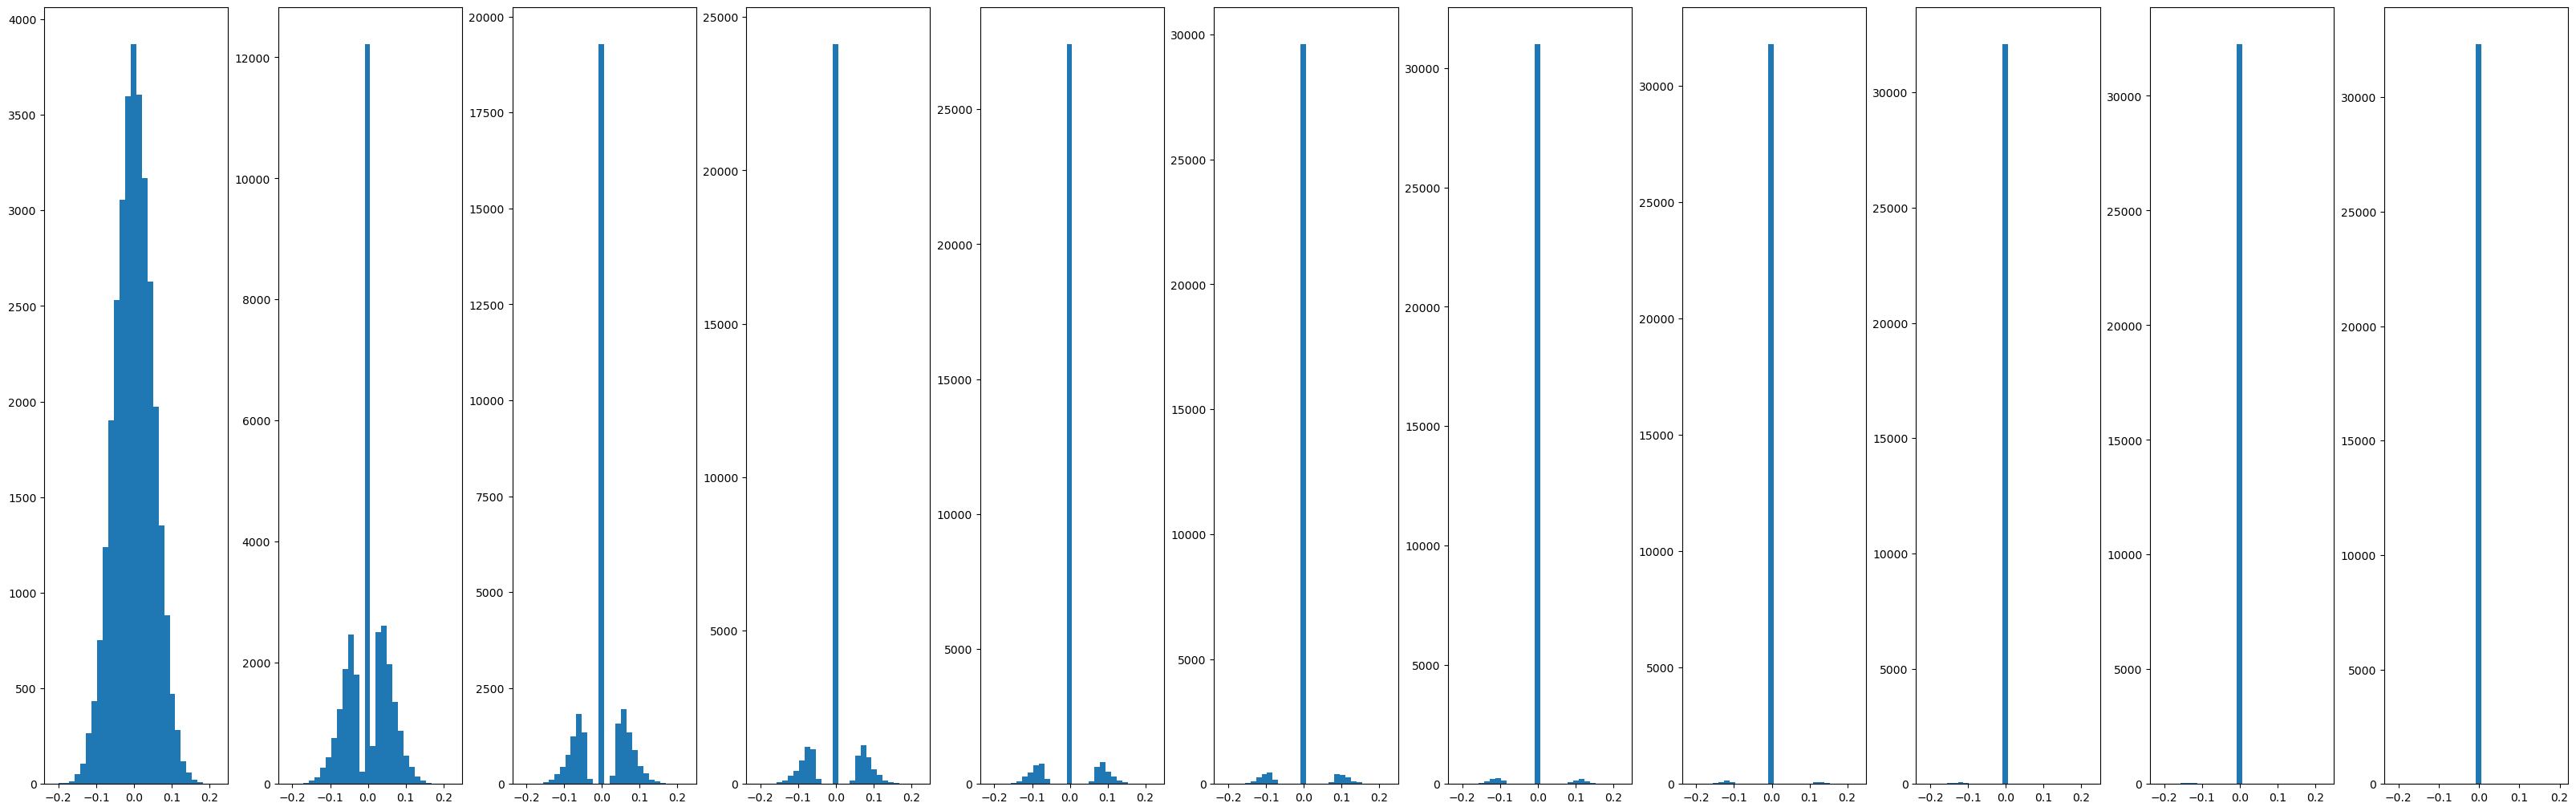

In [53]:
fig, ax = plt.subplots(
    1, e.num_levels,
    figsize=(32,10), 
    constrained_layout=True, 
    sharey=False,               # you can see the differences in amount of weights, but the shape is lost
    )
density=False
for i in range(e.num_levels):
    X = e.weights(level=i, layer=0).reshape(300,28,28)

    shell,core = get_outer_shell_2d_matrix(X)
    #plot_weight_distribution(shell, ax[i], "shell", f"level{i}", False, True, density)
    ax[i].hist(shell, bins=30)
    #plot_weight_distribution(core, ax[i], "core",  f"level{i}", False, True, density)
    #plot_weight_distribution(X, ax[i], "combined",  f"level{i}", False, True, density)

/var/folders/9n/yxn6g0xn02q48jb1vzdss0hm0000gn/T/ipykernel_1232/2009044244.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

/var/folders/9n/yxn6g0xn02q48jb1vzdss0hm0000gn/T/ipykernel_1232/2009044244.py:51: UserWarning:

indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1670525849783/work/aten/src/ATen/native/IndexingUtils.h:28.)



Text(0.5, 0.98, 'Outer Shell versus Core of the MNIST features morph')

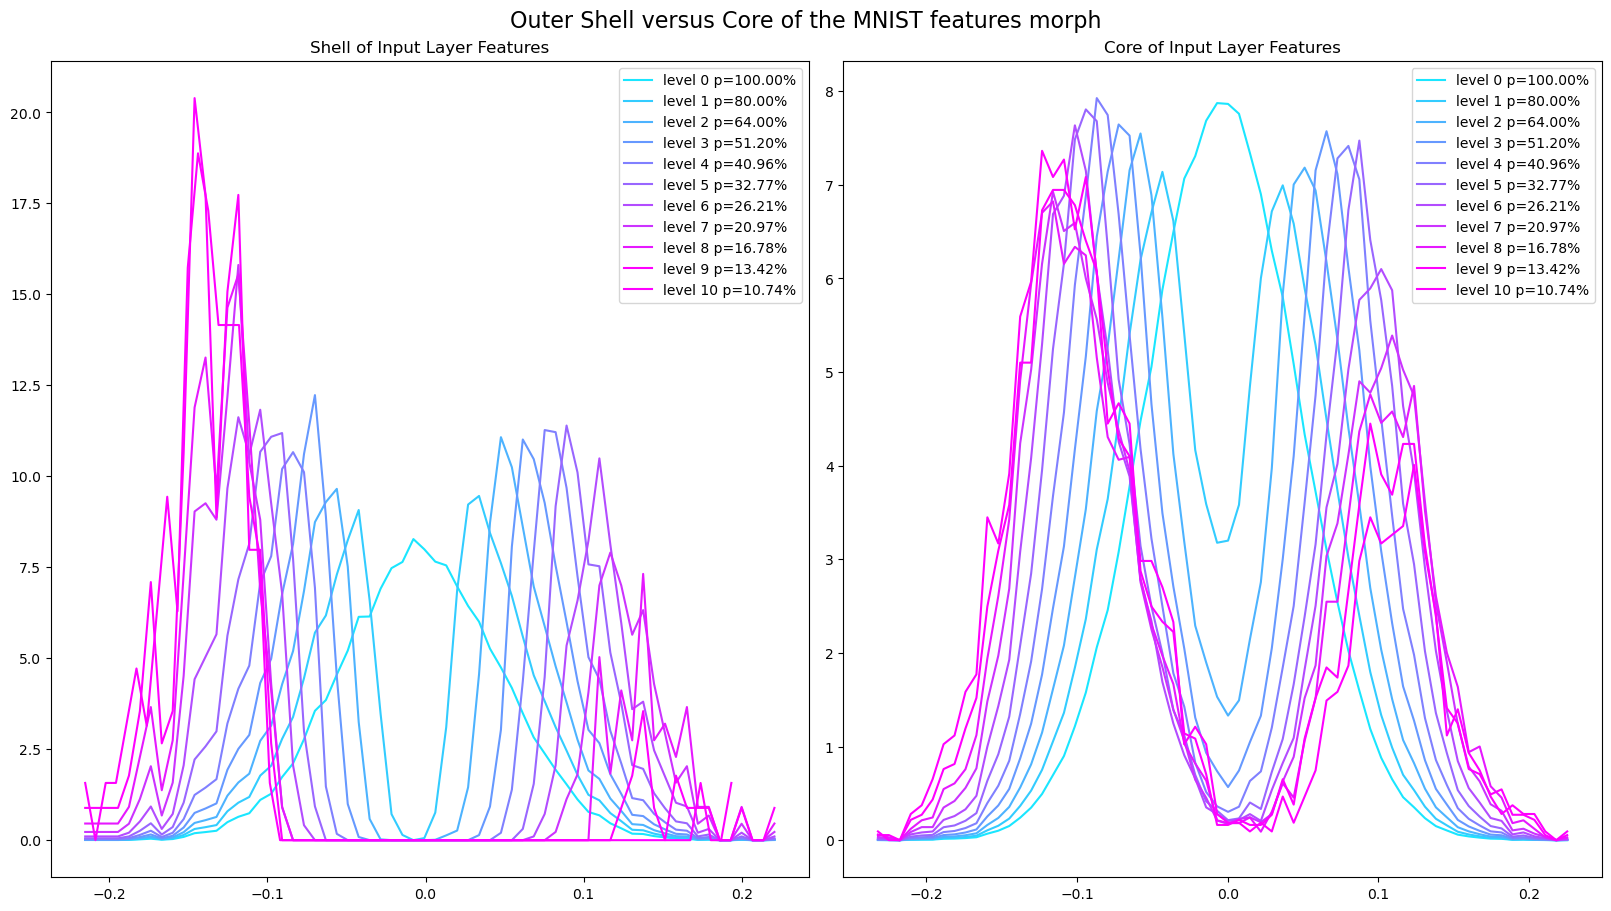

In [54]:
fig, ax = plt.subplots(
    1, 2,
    figsize=(16,9), 
    constrained_layout=True, 
    sharey=False,               # you can see the differences in amount of weights, but the shape is lost
    )

morph_distributions(
    [
    (get_outer_shell_2d_matrix(e.weights(level=i, layer=0).reshape(300,28,28))[0]
    , f"level {i} p={(100*(0.8**i)):.2f}%") 
     for i in range(e.num_levels)
    ],
    ax=ax[0],
    fig=fig,
    title="Shell of Input Layer Features"
)
morph_distributions(
    [
    (get_outer_shell_2d_matrix(e.weights(level=i, layer=0).reshape(300,28,28))[1]
    , f"level {i} p={(100*(0.8**i)):.2f}%") 
     for i in range(e.num_levels)
    ],
    ax=ax[1],
    fig=fig,
    title="Core of Input Layer Features"
)
fig.suptitle('Outer Shell versus Core of the MNIST features morph', fontsize=16)

# Scatter Plot of X-axis = initial position, Y-axis = final position,
Color indicates when the weights were pruned. ?? ! But that doesnt work.....

# Plot which weights are deleted
1. weights at level t
2. mask at level t+1, which was produced in step t
3. select weights that are removed by this neww mask
    * weights at t with inverted mask t+1 where result is not zero

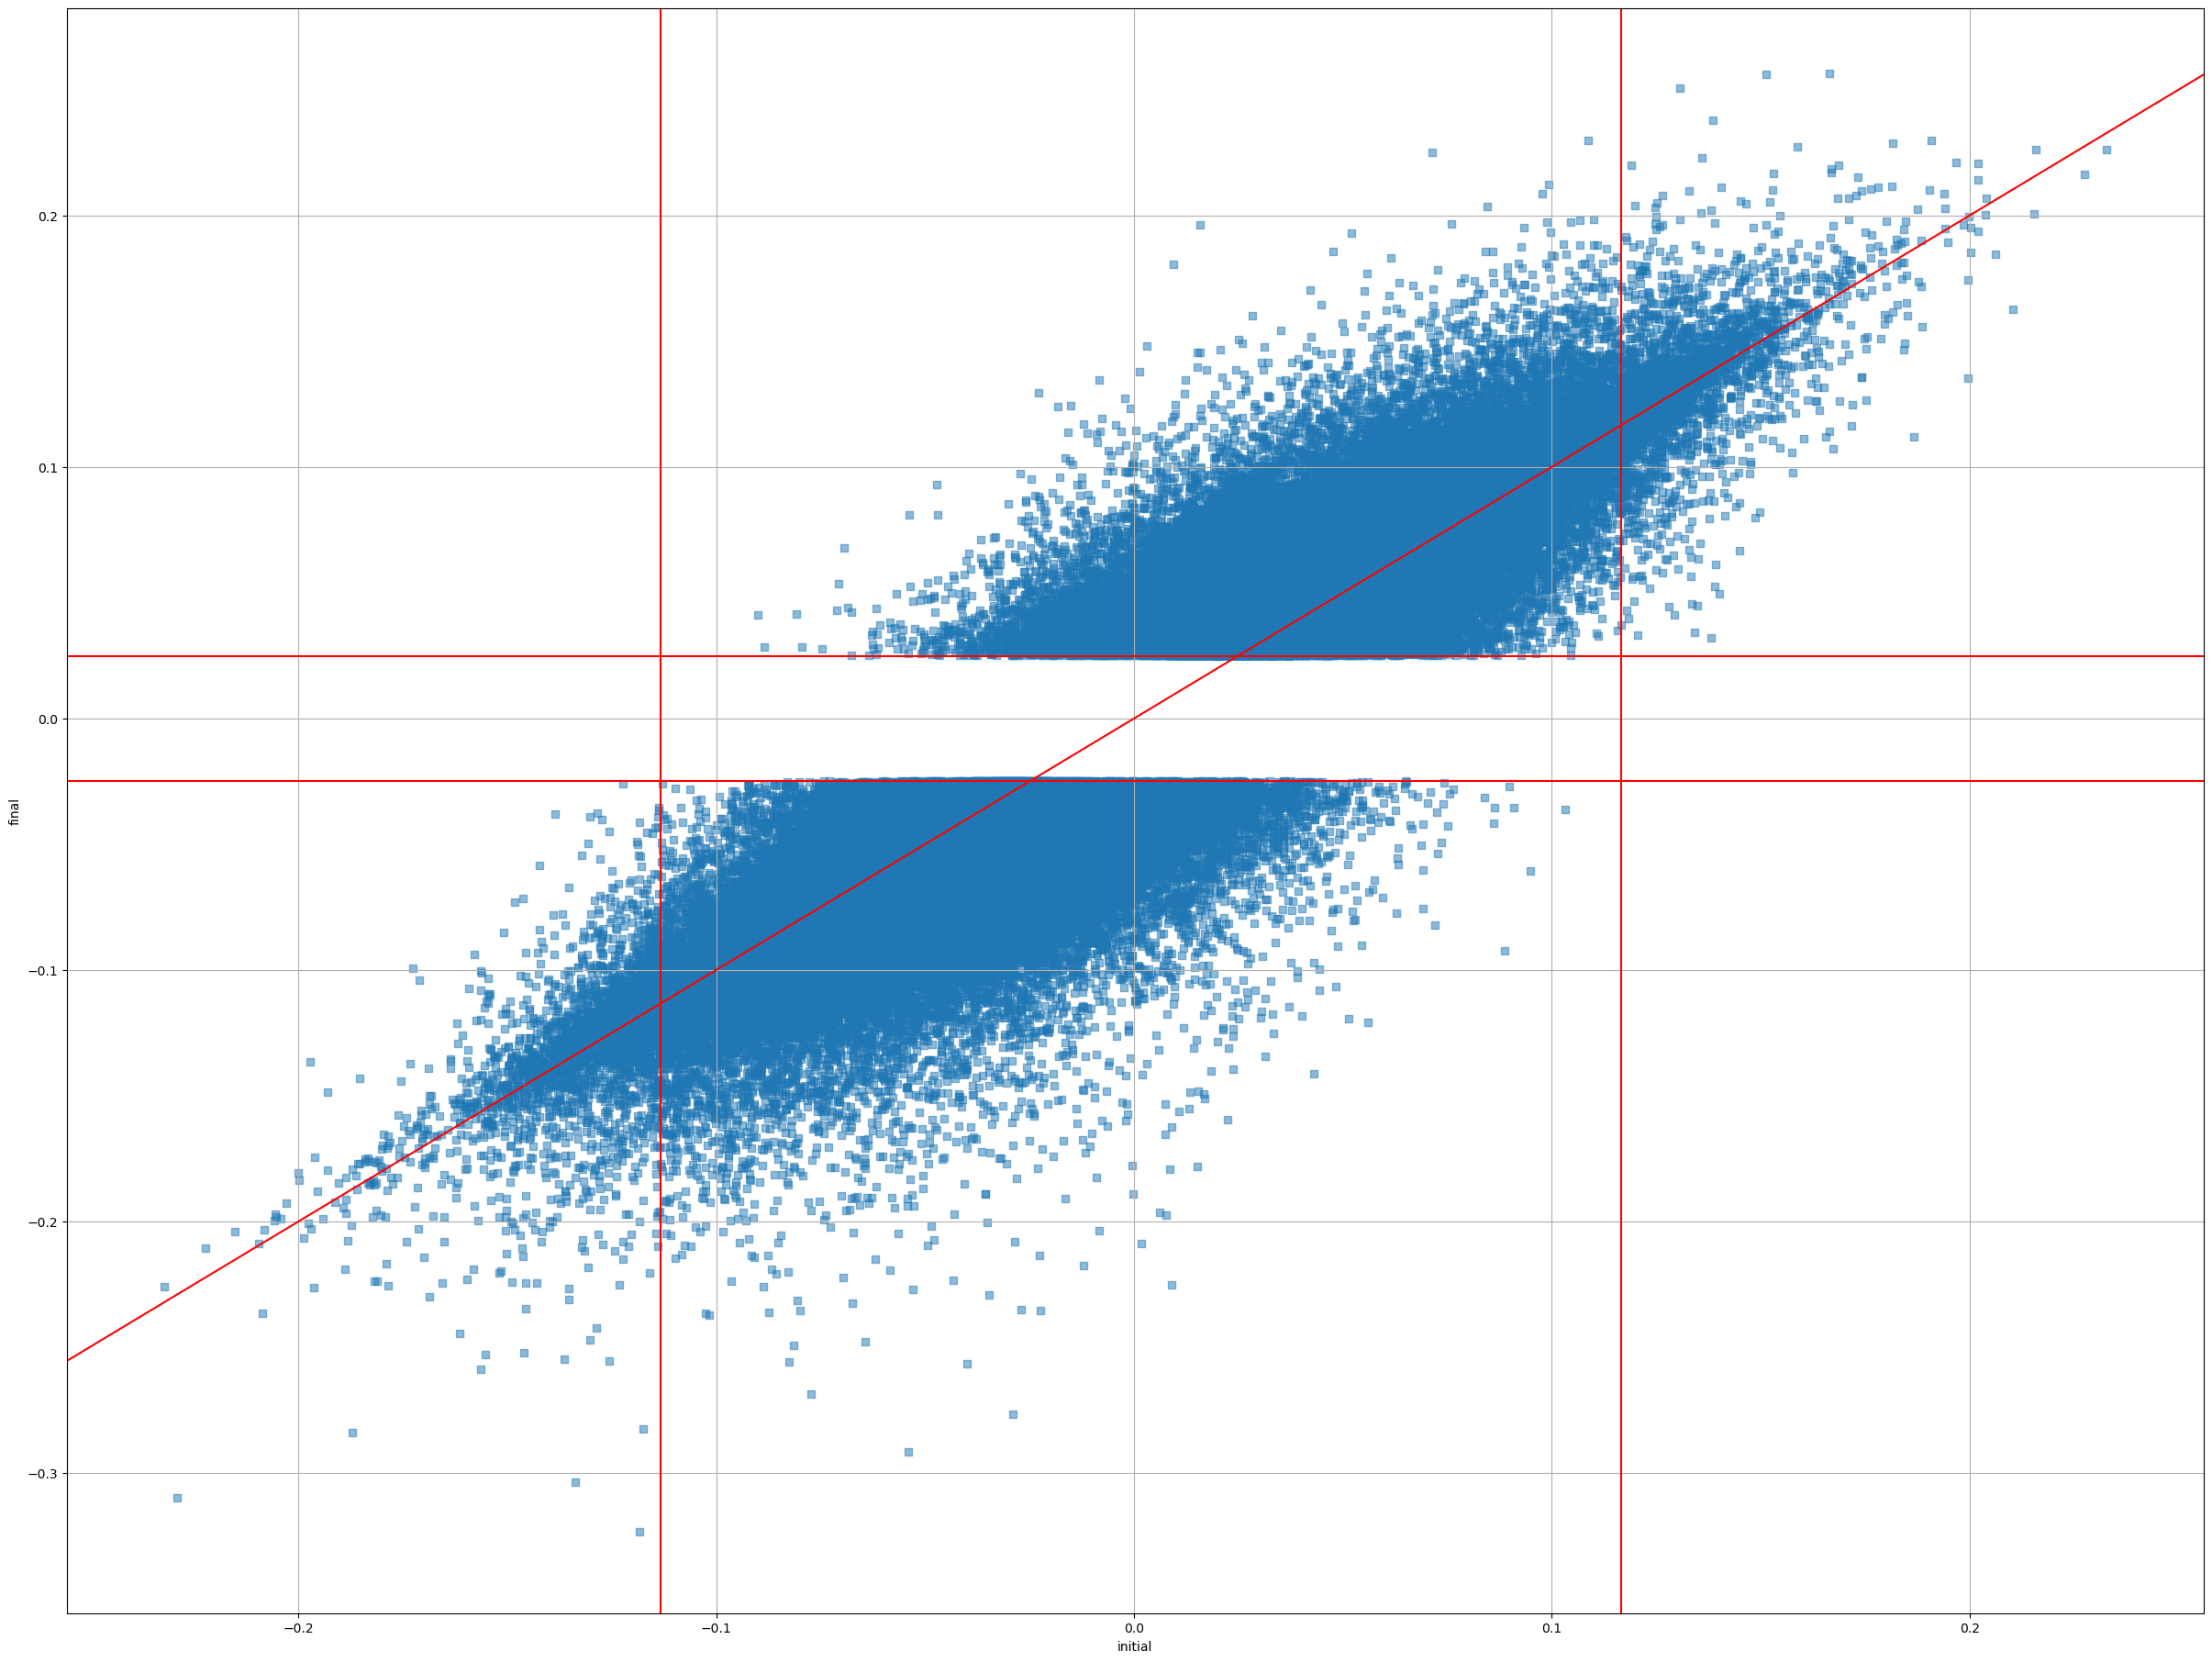

In [55]:
fig, ax = plt.subplots(
    1, 1,
    figsize=(24,18), 
    constrained_layout=True, 
    sharey=False,               # you can see the differences in amount of weights, but the shape is lost
    )

level=0
layer=0

X = e.weights(level, layer)
Y = e.weights(level, layer, ep=e.ep, it=e.it)
m = e.mask(level+1, layer)

x_prune, x_remain = get_pruned_and_remaining_weights(X, m)
y_prune, y_remain = get_pruned_and_remaining_weights(Y, m)


ax.scatter(
    x=x_remain,
    y=y_remain, alpha=0.5,
    marker=","
    )

# ax.scatter(
#     x=x_prune,
#     y=y_prune,
#     marker="x",
#     c="black"
#     )
# prune brorders
x_prune_lower_bound, x_prune_upper_bound = x_prune.min(),x_prune.max()
y_prune_lower_bound, y_prune_upper_bound = y_prune.min(),y_prune.max()
ax.axhline(y_prune_lower_bound, c="red")
ax.axhline(y_prune_upper_bound, c="red")
ax.axvline(x_prune_lower_bound, c="red")
ax.axvline(x_prune_upper_bound, c="red")
line = ax.axline((0,0),(1,1), c="red")

ax.set_xlabel("initial")
ax.set_ylabel("final")
ax.set_ylim(y_remain.min()*1.1, y_remain.max()*1.1)
ax.set_xlim(x_remain.min()*1.1, x_remain.max()*1.1)
ax.grid()

/var/folders/9n/yxn6g0xn02q48jb1vzdss0hm0000gn/T/ipykernel_1232/2009044244.py:4: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



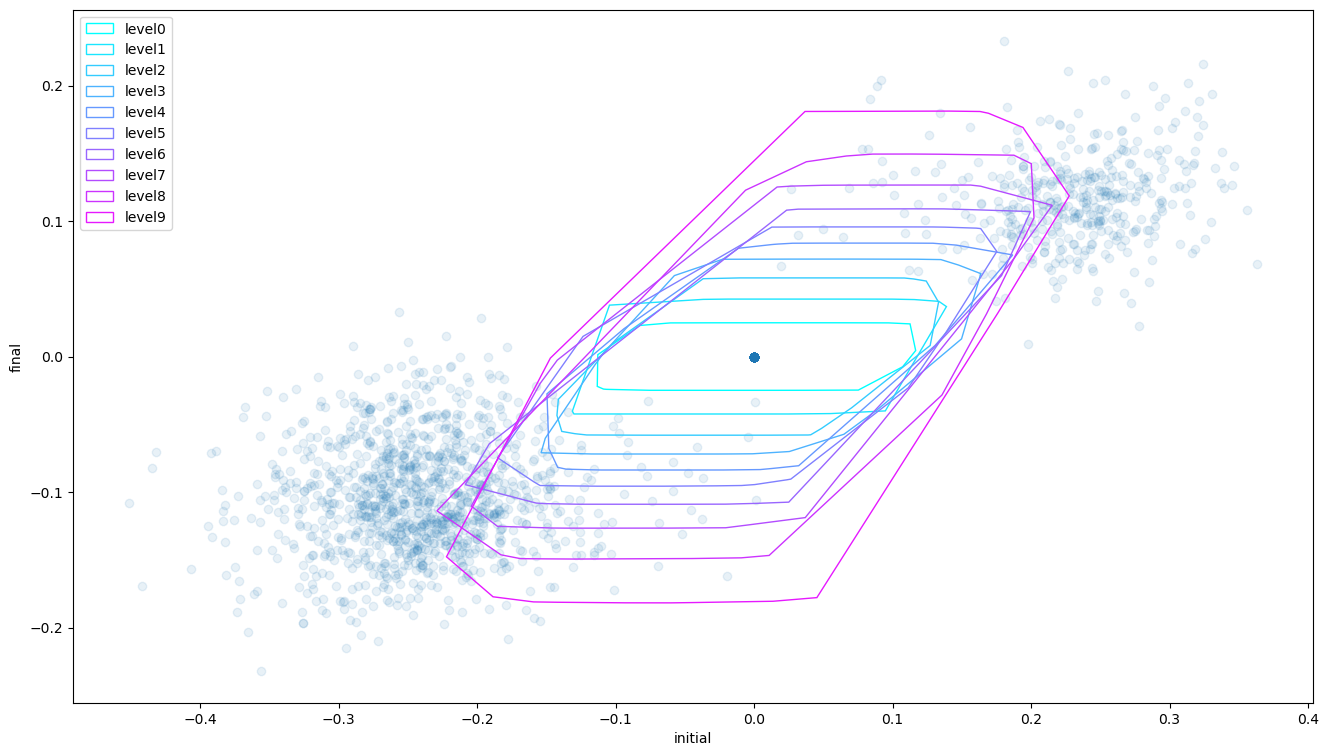

In [56]:
fig, ax = plt.subplots(1,1,figsize=(16,9))

cmap = direct_access_cmap(e.num_levels)    # a discrete colormap
layer=0

X = e.weights(e.num_levels-1, layer)
Y = e.weights(e.num_levels-1, layer, ep=e.ep, it=e.it)
ax.scatter(Y,X, alpha=0.1)

for level in range(e.num_levels-1):
    
    X = e.weights(level, layer)
    Y = e.weights(level, layer, ep=e.ep, it=e.it)
    m = e.mask(level+1, layer)

    x_prune, _ = get_pruned_and_remaining_weights(X, m)
    y_prune, _ = get_pruned_and_remaining_weights(Y, m)

    points = torch.stack((x_prune, y_prune), dim=1)
    poly = points_to_convvex_hull_polygon(np.array(points))

    # prune brorders
    x_up, x_low = x_prune.min(),x_prune.max()
    y_up, y_low = y_prune.min(),y_prune.max()
    poly.set_edgecolor(cmap(level))
    poly.set_label(f"level{level}")
    poly.set_fill("none")
    poly.set_linewidth(1)
    poly.set_alpha(1)


    ax.add_patch(
        poly
    )

    ax.set_xlabel("initial")
    ax.set_ylabel("final")
    #ax.set_ylim(y_low*1.1, y_up*1.1)
    #ax.set_xlim(x_low*1.1, x_up*1.1)
    ax.grid()
    ax.legend()



In [57]:
def insight(X):
    total = X.numel()
    nonzero = X.count_nonzero()
    zero = total-nonzero
    print(f"zeros: {zero}")
    print(f"non-zeros: {nonzero}")
    print(f"total: {total}")
    assert zero + nonzero == total
    
insight(X[e.mask(10, layer)])

zeros: 0
non-zeros: 1575
total: 1575


In [58]:
import plotly.express as px
df = pd.DataFrame(
    {
    "0": e.weights(11,0).flatten(),
     "1" : e.weights(12,0).flatten()
    }
)

fig = px.parallel_coordinates(df,
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

FileNotFoundError: [Errno 2] No such file or directory: 'open_lth_data/lottery_exp2_seedset/replicate_1/level_11/main/model_ep0_it0.pth'

In [ ]:
#pd.DataFrame([e.weights(0,0).flatten(), e.weights(1,0).flatten()], columns = ['level 0','level 1'])
